In [195]:
from bokeh.plotting import figure
from bokeh.layouts import column
from bokeh.models import CDSView, ColumnDataSource, IndexFilter, RadioGroup, Slider, BoxSelectTool, HoverTool
from bokeh.models import BoxEditTool
from bokeh.models.mappers import LinearColorMapper
from bokeh.io import push_notebook, show, output_notebook
from bokeh import palettes
from bokeh.events import Tap, DoubleTap
output_notebook()

Loading BokehJS ...

In [2]:
import random
from functools import partial
import numpy as np
import pandas as pd
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import fitstools
from pathlib import PurePath
import glob

In [3]:
# Get some data into a dataframe
x1 = list(range(0, 10))
y1 = random.sample(range(0, 10), 10)
# Prepare an output dataframe that will contain the labels (initially, there is none)
df = pd.DataFrame({'x':x1, 'y':y1, 'label': 'no label'})
df.set_index('x', inplace=True)

In [4]:
# Data prepped by COR2_tracking_prep.ipynb
datadir = PurePath('C:\Data\STEREO\L7tum\prep_fits')
outputdir = PurePath('C:\Data\STEREO\L7tum\\figures')
datafiles = sorted(glob.glob(str(PurePath(datadir, '*.fits'))))
nfiles = len(datafiles)
nsamples = 80
fov = np.s_[0:659, 0:600]
samples = [np.abs(fitstools.fitsread(datafiles[i], cube=False, astropy=True))[fov] for i in range(10)]

In [104]:
# Given (x,y), define a small local grid to search for local max. 
x = 100
y = 100
x = np.arange(-8, 8) + x
y = np.arange(-15, 15) + y
xx, yy = np.meshgrid(x, y)

In [205]:
# Define the app. The "doc" argument is the container of your app. We add to it the graphs and GUI elements
def bkapp(doc):
    # Define the tools that will appear in the figure toolbar. 
    # The selection tool is necessary, e.g. `box_select`.
    TOOLTIPS = [
        ("x", "$x"),
        ("y", "$y"),
        ("value", "@image"),
    ]
    # tools = ['box_select', 'hover', 'reset']
    tools = ['hover', 'reset']
    # Create the figure axis
    fig = figure(x_axis_label='X [px]',
               y_axis_label='Y [px]',
               title="Test displaying image series",
               tooltips=TOOLTIPS,
               tools=tools)
    
    # def callback_tap(event):
    #     coords=(event.x,event.y)
    #     print(coords)
    # fig.on_event(Tap, callback_tap)
    
    source1 = ColumnDataSource({'x':[], 'y':[], 'width':[], 'height':[]})
    source2 = ColumnDataSource({'x':[], 'y':[], 'width':[], 'height':[]})
    r1 = fig.rect('x', 'y', 'width', 'height', source=source1)
    r2 = fig.rect('x', 'y', 'width', 'height', source=source2)
    tool = BoxEditTool(renderers=[r1, r2], num_objects=2)
    fig.add_tools(tool)
    
    
    fig.x_range.range_padding = fig.y_range.range_padding = 0
    # Display the image
    color_mapper = LinearColorMapper(palette=palettes.Greys256[::-1], low=0, high=4)
    source = ColumnDataSource({'image': [samples[0]]})
    # im = p.image(image=[samples[0]], x=0, y=0, dw=600, dh=659, color_mapper=color_mapper)
    im = fig.image(source=source, x=0, y=0, dw=600, dh=659, color_mapper=color_mapper)

    myslider = Slider(title="amplitude", value=0, start=0, end=10, step=1)
    
    def callback(attr, old, new):
        frame_nb = myslider.value
        print(frame_nb)
        print(new)
        source.data.update({"image": [samples[frame_nb]]})

    # scatter.data_source.selected.on_change('indices', callback1)
    myslider.on_change('value_throttled', callback)
    
    
    
    # Add our GUI and graph in a column layout
    doc.add_root(column(myslider, fig))

In [206]:
show(bkapp)

### Test Blob detection for more automated way of finding local max

In [44]:
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

In [91]:
blobs = blob_log(samples[0], max_sigma=30, num_sigma=10, threshold=1)

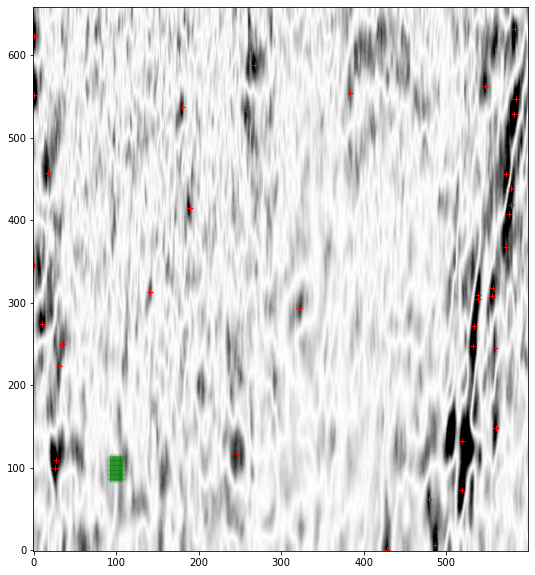

In [103]:
sample = samples[0]
fig = plt.figure(figsize=(10,10))
plt.imshow(sample, origin='lower', vmin=0, vmax=4, cmap='Greys')
plt.plot(blobs[:,1], blobs[:,0], 'r+')
plt.plot(xx.ravel(), yy.ravel(), 'g+', alpha=0.1)